In [1]:
from data import Data
from engine import Engine, TreeClimber
from html_builder import HTMLBuilder
from krakow import krakow
from krakow.utils import create_dendrogram, normalized_dasgupta_cost

import matplotlib.pyplot as plt

import io
import textwrap
from PIL import Image

import numpy as np
import networkx as nx

In [2]:
# data = Data(alpha=1.6, use_cached_forum_data=True, forum="af")
# data = Data(alpha=15, use_cached_forum_data=True, forum="lw")
data = Data(alpha=9, use_cached_forum_data=True, forum="ea")
climber = TreeClimber(data)
engine = Engine(data, climber)

INFO:data:Loading tree from cache


# Drawing the graphs

In [3]:
# # remove tag named "AI"
# tag_slug_to_id = dict()
# for tag in data.tags.values():
#     tag_slug_to_id[tag.slug] = tag._id
# C = data.Tag_cooccurence.copy()
# C.remove_node(tag_slug_to_id["ai"])
# G = C

# # remove disconnected components
# biggest_component = max(nx.connected_components(To_draw), key=len)
# To_draw = To_draw.subgraph(biggest_component)

In [4]:
G = data.Tag_cooccurence
for node in G.nodes:
    G.nodes[node]["weight"] = G[node][node]["weight"]
    G.nodes[node]["name"] = data.tags[node]["name"]

# remove self-edges
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

nodes = sorted(G.nodes(), key=lambda x: G.nodes[x]["weight"], reverse=True)

# for each edge calculate overlap
for u, v, d in G.edges(data=True):
    u_w = G.nodes[u]["weight"]
    v_w = G.nodes[v]["weight"]
    uv_w = d["weight"]
    d["overlap"] = uv_w / (u_w + v_w - uv_w)
    assert 0 <= d["overlap"] <= 1

# wrap node names
for node in G.nodes:
    G.nodes[node]["name"] = textwrap.fill(G.nodes[node]["name"], 14)

In [12]:
num_of_nodes = 50

# create a subgraph with given nodes
To_draw = G.subgraph(nodes[:num_of_nodes])

In [19]:
# * implement a hierarchichal spring layout
attr = "overlap"
repulsive_force = 0.1
attractive_force = 0.1

# initialize positions
for node in To_draw.nodes:
    To_draw.nodes[node]["pos"] = np.random.rand(2) * 2 - 1

# calculate repulsive forces
for i, node1 in enumerate(To_draw.nodes):
    for j, node2 in enumerate(To_draw.nodes):
        if i >= j:
            continue
        pos1 = To_draw.nodes[node1]["pos"]
        pos2 = To_draw.nodes[node2]["pos"]
        diff = pos2 - pos1
        dist = np.linalg.norm(diff)
        if dist == 0:
            dist = 0.00001
        force = diff / dist * (1 / dist) ** 2 * repulsive_force
        To_draw.nodes[node1]["pos"] -= force
        To_draw.nodes[node2]["pos"] += force
        
# calculate attractive forces
for u, v, d in To_draw.edges(data=True):
    pos1 = To_draw.nodes[u]["pos"]
    pos2 = To_draw.nodes[v]["pos"]
    diff = pos2 - pos1
    dist = np.linalg.norm(diff)
    if dist == 0:
        dist = 0.00001
    force = diff / dist * (dist ** 2) * attractive_force * d[attr]
    To_draw.nodes[u]["pos"] += force
    To_draw.nodes[v]["pos"] -= force

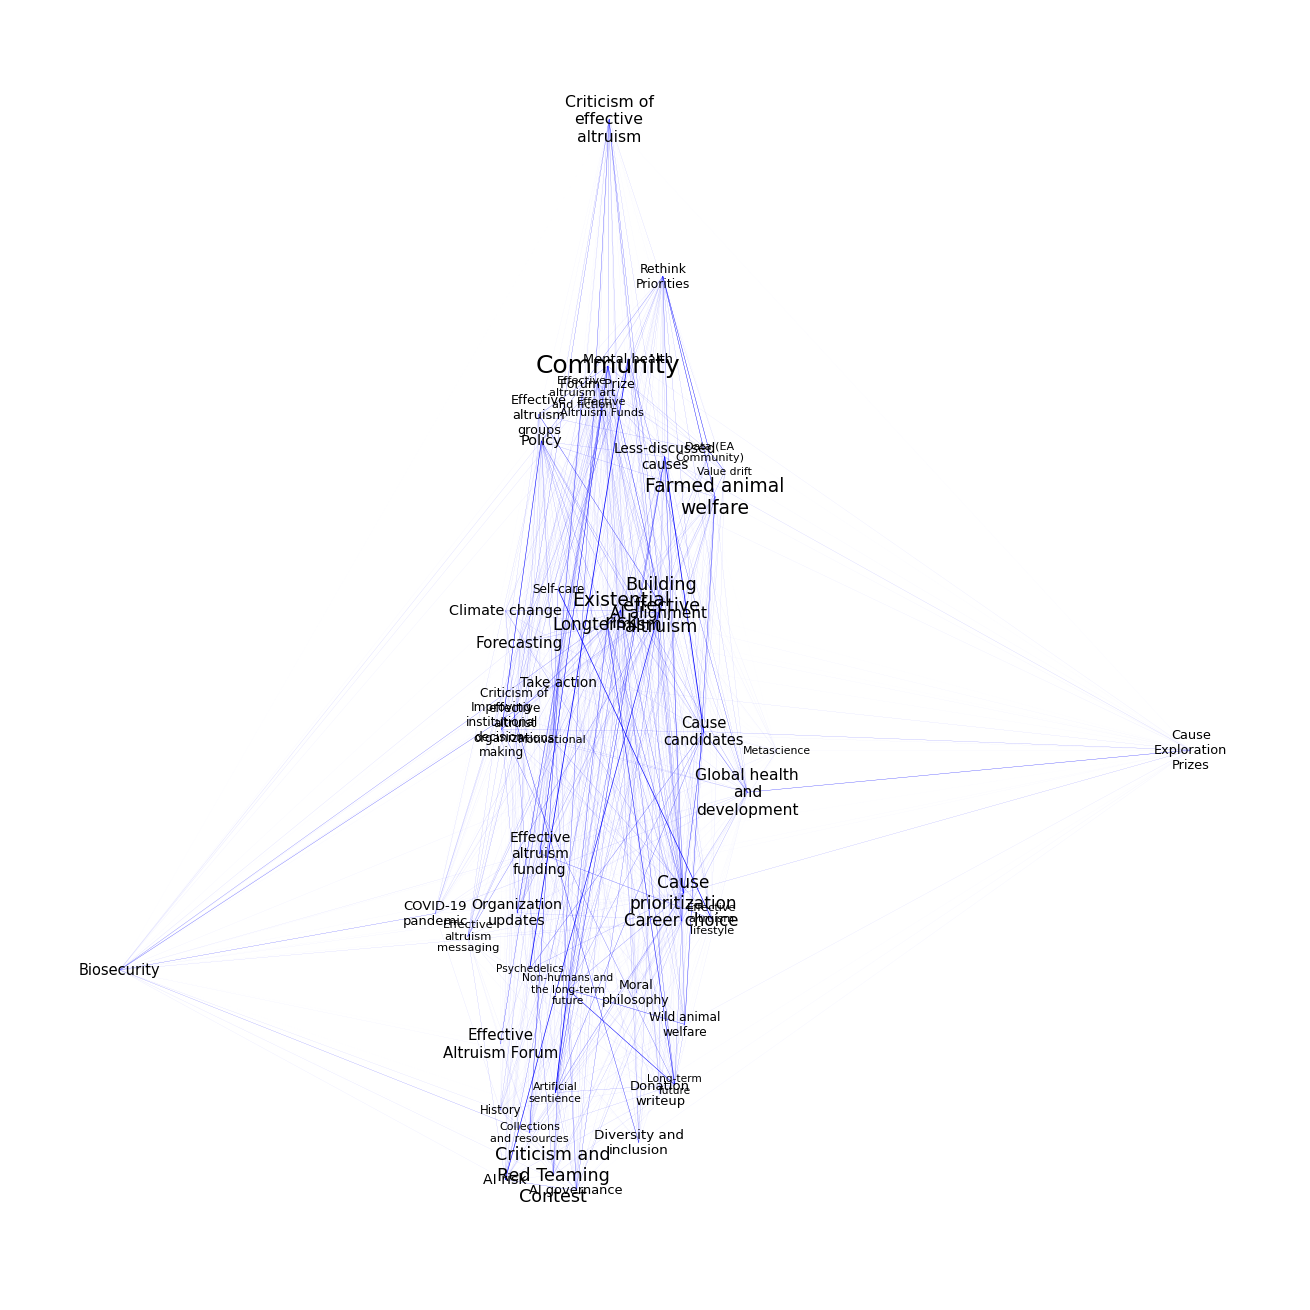

In [20]:
pos = {node: To_draw.nodes[node]["pos"] for node in To_draw.nodes}
# pos = nx.spring_layout(
#     To_draw, 
#     iterations=50,
#     weight="overlap",
#     # pos=old_pos,
#     # fixed=old_pos.keys(),
# )

max_weight = max([edge[2]["weight"] for edge in To_draw.edges(data=True)])
plt.figure(figsize=(18, 18))
nx.draw(
    To_draw,
    node_size=0,
    # width=[edge[2]["weight"] / max_weight for edge in To_draw.edges(data=True)],
    width=[edge[2]["overlap"] * 3 for edge in To_draw.edges(data=True)],
    edge_color="blue",
    pos=pos,
)

# draw labels
largest_tag_weight = max(node_data["weight"] for _, node_data in To_draw.nodes(data=True))
for node, (x, y) in pos.items():
    name = To_draw.nodes[node]["name"]
    size = (To_draw.nodes[node]["weight"] / largest_tag_weight) ** 0.4 * 25
    plt.text(x, y, name, fontsize=size, color="black", ha='center', va='center')

# add pos data to graph
for node, (x, y) in pos.items():
    To_draw.nodes[node]["pos"] = (x, y)


In [8]:
import json

filename = "../interactive/tag_net.json"
_edges = nx.to_dict_of_dicts(To_draw)
_nodes = {node: To_draw.nodes[node] for node in To_draw.nodes}
json.dump((_nodes, _edges), open(filename, "w"))

In [9]:
_edges

{'xoZfSjT2oXLYnDfmN': {'4CH9vsvzyk4mSKwyZ': {'weight': 1.0,
   'overlap': 0.00033760972316002703},
  'ZCihBFp5P64JCvQY6': {'weight': 27.0, 'overlap': 0.0034874709377421854},
  'ee66CtAMYurQreWBH': {'weight': 4.0, 'overlap': 0.001021972406745018},
  '2BvgFyR85zX25osTT': {'weight': 8.0, 'overlap': 0.01616161616161616},
  'EHLmbEmJ2Qd5WfwTb': {'weight': 2.0, 'overlap': 0.0005884083553986466},
  't2L2RziMDLEuHBWNF': {'weight': 52.0, 'overlap': 0.017496635262449527},
  '5xoQz7ZNnXiC2Bhmp': {'weight': 1.0, 'overlap': 0.0009718172983479105},
  'CGameg7coDgLbtgdH': {'weight': 1.0, 'overlap': 0.00042283298097251583},
  'oNiQsBHA3i837sySD': {'weight': 16.0, 'overlap': 0.028268551236749116},
  'RhWCRXjTagDpLk2L5': {'weight': 1.0, 'overlap': 0.0023752969121140144},
  'dEonhiqoaQRnwnoAt': {'weight': 11.0, 'overlap': 0.022494887525562373},
  'z8qFsGt5iXyZiLbjN': {'weight': 8.0, 'overlap': 0.004188481675392671},
  'bBS5GQJgFcobNBLki': {'weight': 23.0, 'overlap': 0.011031175059952039},
  'kBxmJcNsf3p6

# Analyze the distribution of votes

In [ ]:
from collections import Counter

big_up_ratios = []
sma_up_ratios = []
sma_down_ratios = []
big_down_ratios = []

for post in data.posts.values():
    num_of_votes = len(post.allVotes)
    vote_types = [vote["voteType"] for vote in post.allVotes]
    vote_types = Counter(vote_types)
    # if post._id == "":
    #     print(post.title)
    #     print(vote_types["bigDownvote"], vote_types["smallDownvote"], vote_types["smallUpvote"], vote_types["bigUpvote"])
    if num_of_votes == 0:
        continue
    big_up_ratios.append(vote_types["bigUpvote"] / num_of_votes)
    sma_up_ratios.append(vote_types["smallUpvote"] / num_of_votes)
    sma_down_ratios.append(vote_types["smallDownvote"] / num_of_votes)
    big_down_ratios.append(vote_types["bigDownvote"] / num_of_votes)

In [ ]:
# plot histogram of vote ratios
plt.hist(big_up_ratios, bins=20, alpha=0.5, label="bigUpvote")
plt.hist(sma_up_ratios, bins=20, alpha=0.5, label="smallUpvote")
plt.legend(loc="upper right")

In [ ]:
plt.hist(big_down_ratios, bins=20, range=(0, 1), alpha=0.5, label="bigDownvote")
plt.hist(sma_down_ratios, bins=20, range=(0, 1),alpha=0.5, label="smallDownvote")
plt.legend(loc="upper right")

# Analyze cracy of posts

In [ ]:
all_posts = data.posts.values()
# filter out posts where one of the scores is negative
# find the median ratio
_demo = np.array([post["democraticScore"] for post in all_posts])
_meri = np.array([post["meritocraticScore"] for post in all_posts])
_regu = np.array([post["baseScore"] for post in all_posts])
# median_ratio = np.median(_meri / _demo)

# make the axes equal and rectangular
plt.figure(figsize=(10,10))
# chop off at 0
plt.xlim(-50, 600)
plt.ylim(-50, 600)
# plot line with a slope of the median ratio
plt.plot([-50, 600], [-50, 600], color="white", linewidth=0.5)
# plot 0 lines
plt.plot([-50, 600], [0, 0], color="white", linewidth=0.5)
plt.plot([0, 0], [-50, 600], color="white", linewidth=0.5)
plt.scatter(_demo, _meri, s=1)
# add labels
plt.xlabel("Democratic score")
plt.ylabel("Meritocratic score")

In [ ]:

avg_big_vote_component = np.mean([p.baseScore - p.smallBalance for p in all_posts])
avg_big_balance = np.mean([p.bigBalance for p in all_posts])
avg_vote_power = avg_big_vote_component / avg_big_balance
avg_vote_power

In [ ]:
# calculate correlation between meritocratic and democratic scores
from scipy.stats import pearsonr
pearsonr([p.meritocraticScore for p in all_posts], [p.democraticScore for p in all_posts])

In [ ]:
f = lambda p: p.democraticScore

sorted_posts = sorted([post for post in filtered_posts if post.democraticScore*median_ratio > post.meritocraticScore], key=f, reverse=True)[:25]
for post in sorted_posts:
    print(f"{post.bigDownvotes:3} {post.smallDownvotes:3} {post.smallUpvotes:3} {post.bigUpvotes:3}     {post.democraticScore:3} {post.baseScore:3} {post.meritocraticScore:3}     {post.cracy:.3f} {post.title}")

In [ ]:
f = lambda p: p.meritocraticScore

sorted_posts = sorted([post for post in filtered_posts if post.democraticScore*median_ratio <= post.meritocraticScore], key=f, reverse=True)[:25]
for post in sorted_posts:
    print(f"{post.bigDownvotes:3} {post.smallDownvotes:3} {post.smallUpvotes:3} {post.bigUpvotes:3}     {post.democraticScore:3} {post.baseScore:3} {post.meritocraticScore:3}     {post.cracy:.3f} {post.title}")

# Analyze overlap of tags

In [ ]:
# find tags with highest cooccurence
cooccurence_data = [(u, v, edge_data["weight"]) for u, v, edge_data in data.Tag_cooccurence.edges(data=True)]

# normalize cooccurences by the size of two tags
normalized_cooccurences = dict()
for u, v, cooccurence in cooccurence_data:
    u_size = data.Tag_cooccurence[u][u]["weight"]
    v_size = data.Tag_cooccurence[v][v]["weight"]
    sum_of_occurence = u_size + v_size - cooccurence
    normalized_cooccurences[(u, v)] = cooccurence / sum_of_occurence

# sort by normalized cooccurence
sorted_cooccurences = sorted(normalized_cooccurences.items(), key=lambda x: x[1], reverse=True)

# print tags with highest overlap
for (u, v), cooccurence in sorted_cooccurences:
    if u == v:
        continue
    print(f'{data.tags[u]["name"]:30} {data.tags[v]["name"]:30} {cooccurence:.3f}')

In [ ]:
for post in data.posts.values():
    print(post["commentCount"])
    # if post["commentCount"] is None:
    #     print(post["title"])

In [ ]:
tag_scores = dict()
for post in data.posts.values():
    for tag, relevance in post["tagRelevance"].items():
        if tag not in tag_scores:
            tag_scores[tag] = []
        tag_scores[tag].append((post["baseScore"], relevance))

In [ ]:
# tags_sorted_by_quality = sorted(tag_quality.items(), key=lambda x: np.average(x[1][0], weights=x[1][1]), reverse=True)

tag_qualities = dict()
for tag, scores_and_relevances in tag_scores.items():
    scores, relevances = zip(*scores_and_relevances)
    quality = np.average(scores, weights=relevances)
    tag_qualities[tag] = quality

tags_sorted_by_quality = sorted(tag_qualities.items(), key=lambda x: x[1], reverse=True)


In [ ]:
for tag_id, quality in tags_sorted_by_quality:
    scores = [score for score, relevance in tag_scores[tag_id]]
    if len(scores) < 2:
        continue
    if tag_id not in data.tags:
        print(f"{tag_id} not in tags")
        continue
    print(f'{data.tags[tag_id]["name"]:50} {quality:.0f}     {scores}')

# Analyze score distribution

In [ ]:
scores = [post["baseScore"] for post in data.posts.values()]

In [ ]:
# plot histogram of scores
plt.hist(scores, bins=100, range=(-10, 200))
None

In [ ]:
log_scores = np.log(np.clip(scores, 1, None))

In [ ]:
# plot histogram of log scores
plt.hist(log_scores, bins=50)
None

In [ ]:
sorted_posts = sorted(data.posts.values(), key=lambda x: x["baseScore"], reverse=True)

In [ ]:
sorted_posts[-2]

In [ ]:
# find which percentile a score 52
percentile = np.percentile(scores, 80.2)
percentile

# Investigate tags present in posts, but not listed by GraphQL query

In [ ]:
for post in data.posts.values():
    if "ZJEM3pibQmic8Rp5G" in post["tagRelevance"]:
        print(post)
        print()

In [ ]:
for tag in data.tags.values():
    if tag["name"] == "Community":
        print(tag)
        print()

In [ ]:
data.tags["Sgx48Pf8PzmTxSEEG"]

In [ ]:
"Community" "Frontpage"

In [ ]:
data.posts["rDAZancpWpMwxjoFg"]